In [1]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
# Path to the folder containing the CSV files
path = "data/data_ilr_transformed/"

# Generate a list of file paths for the long datasets
file_list = [f"{path}d_study{i}_long.csv" for i in range(1, 9)]

# Read and combine all datasets into one DataFrame
df = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)

# Check the resulting combined DataFrame
print(f"Combined dataset shape: {df.shape}")

ilr_columns = ['ilr1', 'ilr2', 'ilr3']
control_columns = ['excluded', 'injustice', 'personal', 'violence']

Combined dataset shape: (15424, 18)


In [3]:
df = df[df['gender'].notna()]
df = df[df['age'].notna()]

# Feature engineering

In [ ]:
# Creating -1 and -2 lag features for each ilr variable
for col in ilr_columns:
    df[f'{col}_lag1'] = df.groupby('ID')[col].shift(1)
    df[f'{col}_lag2'] = df.groupby('ID')[col].shift(2)

# Calculate mean and standard deviation per participant (ID) for each ilr column
for col in ilr_columns:
    # Mean per participant
    df[f'{col}_mean'] = df.groupby('ID')[col].transform('mean')
    
    # Standard deviation per participant
    df[f'{col}_std'] = df.groupby('ID')[col].transform('std')
    
    # Minimum and maximum values per participant
    df[f'{col}_min'] = df.groupby('ID')[col].transform('min')
    df[f'{col}_max'] = df.groupby('ID')[col].transform('max')


# Additional time-based feature: time point relative to the total duration for each participant
# This provides a scaled measure of progression within the time series
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())


# Optional cumulative feature: cumulative sum of the 'ilr' values within each participant's time series
# This can capture a trend or overall trajectory for each ilr over time
#for col in ilr_columns:
#    df[f'{col}_cumsum'] = df.groupby('ID')[col].cumsum()


## Response Variability Over Time:
#for col in ilr_columns:
#    df[f'{col}_delta'] = df.groupby('ID')[col].diff().fillna(0)  # Absolute change from previous time point


## Interaction Terms: Control Variables with Time
#for col in control_columns:
#    df[f'{col}_time_interaction'] = df[col] * df['time']


# Calculate deviation from the mean of each ilr value within each experiment and time point
#for col in ilr_columns:
#    df[f'{col}_deviation_from_group'] = df[col] - df.groupby(['Experiment', 'time'])[col].transform('mean')


# Calculate the trend/slope for each ilr column
#from sklearn.linear_model import LinearRegression
#for col in ilr_columns:
#    df[f'{col}_trend'] = df.groupby('ID').apply(lambda x: 
#        LinearRegression().fit(x[['time']], x[col]).coef_[0] if len(x) > 1 else np.nan).reset_index(level=0, drop=True)


# Moving Average or Exponential Moving Average (EMA)
window_size = 3  # Define your preferred window size
for col in ilr_columns:
    df[f'{col}_moving_avg'] = df.groupby('ID')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    # df[f'{col}_ema'] = df.groupby('ID')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())

In [5]:
from statsmodels.regression.mixed_linear_model import MixedLM

# List of ilr columns
ilr_columns = ['ilr1', 'ilr2', 'ilr3']
ilr_moving_avg_cols = ['ilr1_moving_avg', 'ilr2_moving_avg', 'ilr3_moving_avg']

# Residualize each ilr variable
for col in ilr_moving_avg_cols:
    # Fit the mixed-effects model
    model = MixedLM.from_formula(f"{col} ~ relative_time", groups="Experiment", data=df)
    result = model.fit()
    
    # Add residuals to the DataFrame
    df[f'{col}_residual'] = df[col] - result.fittedvalues

ilr_resid_columns = ['ilr1_residual', 'ilr2_residual', 'ilr3_residual']

In [6]:
import numpy as np
import pandas as pd

# Number of Fourier components to retain
fourier_components = 1

ilr_moving_avg_residual_cols = ['ilr1_moving_avg_residual', 'ilr2_moving_avg_residual', 'ilr3_moving_avg_residual']

# Compute Fourier transform for each 'ilr' variable per participant
for col in ilr_moving_avg_residual_cols:
    def compute_fourier(x):
        fft_vals = np.fft.fft(x)
        # Retain only the first N components (real and imaginary parts)
        return np.hstack([fft_vals.real[:fourier_components], fft_vals.imag[:fourier_components]])

    # Apply Fourier transformation and store as separate columns
    fourier_df = (
        df.groupby('ID')[col]
        .apply(lambda x: compute_fourier(x.values))
        .apply(pd.Series)
        .rename(columns=lambda i: f'{col}_fourier_{i+1}')
    )

    # Add Fourier features back to the dataframe
    df = df.join(fourier_df, on='ID')


In [127]:
from sklearn.decomposition import PCA

# Apply PCA to Fourier features
fourier_features = df[[col for col in df.columns if 'fourier' in col]].values
pca = PCA(n_components=5)  # Choose a suitable number of components
pca_features = pca.fit_transform(fourier_features)

# Add PCA components back to the DataFrame
for i in range(pca_features.shape[1]):
    df[f'fourier_pca_{i+1}'] = pca_features[:, i]


In [7]:
df.columns

Index(['time', 'ID', 'ina', 'na', 'nna', 'enna', 'ilr1', 'ilr2', 'ilr3',
       'excluded', 'injustice', 'personal', 'violence', 'Vignette', 'gender',
       'age', 'condition', 'Experiment', 'ilr1_lag1', 'ilr1_lag2', 'ilr2_lag1',
       'ilr2_lag2', 'ilr3_lag1', 'ilr3_lag2', 'ilr1_mean', 'ilr1_std',
       'ilr1_min', 'ilr1_max', 'ilr2_mean', 'ilr2_std', 'ilr2_min', 'ilr2_max',
       'ilr3_mean', 'ilr3_std', 'ilr3_min', 'ilr3_max', 'relative_time',
       'ilr1_moving_avg', 'ilr2_moving_avg', 'ilr3_moving_avg',
       'ilr1_moving_avg_residual', 'ilr2_moving_avg_residual',
       'ilr3_moving_avg_residual', 'ilr1_moving_avg_residual_fourier_1',
       'ilr1_moving_avg_residual_fourier_2',
       'ilr2_moving_avg_residual_fourier_1',
       'ilr2_moving_avg_residual_fourier_2',
       'ilr3_moving_avg_residual_fourier_1',
       'ilr3_moving_avg_residual_fourier_2'],
      dtype='object')

# K-means with DTW

## Data preparation

### No normalization whatsoever + Experiment excluded

In [4]:
# Preprocess each participant’s data into a time series format
# Group by ID to collect each participant’s time series data
# Structure each participant's data as a list of [ilr1, ilr2, ilr3, excluded, injustice, personal, violence]

time_series_data = []
grouped = df.groupby("ID")

for participant, group in grouped:
    # Sort by 'time' to ensure the sequence is in order
    group_sorted = group.sort_values("time")
    
    # Extract relevant variables (including control variables) as a list of lists
    time_series = group_sorted[['ilr1', 'ilr2', 'ilr3', 'excluded', 'injustice', 'personal', 'violence']].values
    
    # Normalize lengths by padding or truncating to the max time length if necessary (for equal lengths)
    max_length = 16  # Adjust this as appropriate for your dataset
    if len(time_series) < max_length:
        # Pad with NaNs or some other value to standardize length
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        # Truncate if longer
        time_series = time_series[:max_length]
    
    # Append to the list
    time_series_data.append(time_series)
    
# Convert to numpy array for tslearn (ignoring NaNs in DTW, or filling them if necessary)
time_series_data = np.array(time_series_data)

# Step 3: Scale the data
# Scaling each feature within each time series
# scaled_data = TimeSeriesScalerMeanVariance().fit_transform(time_series_data)

### Normalization after feature engineering

In [8]:
# Step 2: Prepare Time Series Data for Clustering
# Collect each participant’s data with the new features into a standardized time series format

time_series_data = []
grouped = df.groupby("ID")

# Define the feature columns to include in time series
feature_columns = [
    # 'condition', 
    'gender', 'age',
    #'ilr1', 'ilr2', 'ilr3', 
    'excluded', 'injustice', 'personal', 'violence',
    #'ilr1_lag1', 'ilr2_lag1', 'ilr3_lag1', 'ilr1_lag2', 'ilr2_lag2', 'ilr3_lag2',
    #'ilr1_mean', 'ilr2_mean', 'ilr3_mean', 'ilr1_std', 'ilr2_std', 'ilr3_std',
    #'ilr1_min', 'ilr2_min', 'ilr3_min', 'ilr1_max', 'ilr2_max', 'ilr3_max',
    'relative_time', 
    ######'ilr1_cumsum', 'ilr2_cumsum', 'ilr3_cumsum', 
    ######'ilr1_delta', 'ilr2_delta', 'ilr3_delta',  ### definitely nono
    #'excluded_time_interaction', 'injustice_time_interaction', 'personal_time_interaction', 'violence_time_interaction',
    #'ilr1_deviation_from_group', 'ilr2_deviation_from_group', 'ilr3_deviation_from_group',
    #'ilr1_trend', 'ilr2_trend', 'ilr3_trend', 
    # 'ilr1_moving_avg', 'ilr2_moving_avg', 'ilr3_moving_avg', 
    ######'ilr1_ema', 'ilr2_ema', 'ilr3_ema',
    #'ilr1_residual', 'ilr2_residual', 'ilr3_residual',
    #'ilr1_fourier_1', 'ilr2_fourier_1', 'ilr3_fourier_1',
    #'ilr1_fourier_2', 'ilr2_fourier_2', 'ilr3_fourier_2'
    # 'ilr1_moving_avg_fourier_1', 'ilr2_moving_avg_fourier_2', 'ilr3_moving_avg_fourier_1',
    'ilr1_moving_avg_residual_fourier_1',
    #'ilr1_moving_avg_residual_fourier_2',
    'ilr2_moving_avg_residual_fourier_1',
    #'ilr2_moving_avg_residual_fourier_2',
    'ilr3_moving_avg_residual_fourier_1',
    #'ilr3_moving_avg_residual_fourier_2'

]

# Preprocess the time series data for each participant
for participant, group in grouped:
    group_sorted = group.sort_values("time")
    time_series = group_sorted[feature_columns].values
    
    # Pad or truncate each participant's time series to the same length
    max_length = 16  # Adjust as necessary
    if len(time_series) < max_length:
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        time_series = time_series[:max_length]
    
    time_series_data.append(time_series)

# Convert to numpy array for clustering
time_series_data = np.array(time_series_data)

### Normalization per time point per experiment

In [ ]:
# Step 1: Normalize `ilr` columns within each experiment and time point
df[ilr_columns] = df.groupby(['Experiment', 'time'])[ilr_columns].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Step 2: Normalize control variables globally across the entire dataset
scaler = StandardScaler()
df[control_columns] = scaler.fit_transform(df[control_columns])

# Step 3: Prepare time series data with the normalized `ilr` and control variables
time_series_data = []
grouped = df.groupby("ID")

for participant, group in grouped:
    group_sorted = group.sort_values("time")
    
    # Extract relevant normalized variables for each participant’s time series data
    time_series = group_sorted[ilr_columns + control_columns].values
    
    # Standardize the length by padding or truncating to max length (e.g., 16)
    max_length = 16  # Adjust as appropriate for your dataset
    if len(time_series) < max_length:
        # Pad with NaNs to reach the standard length
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        # Truncate to the maximum length if longer
        time_series = time_series[:max_length]
    
    time_series_data.append(time_series)

# Convert to a numpy array for further processing
time_series_data = np.array(time_series_data)


# Step 4: Separate ilr variables and control variables in the time series data
# Step 5: Scale only the control variables per time series
# >>> I am skipping these steps!

## Single clustering tryout

In [9]:
# Set number of clusters (use elbow method result or other criteria)
n_clusters = 3

# Fit the clustering model
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(time_series_data)

# Add labels to the original DataFrame for analysis
df["cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), labels)))

## Summary

In [10]:
# Create a summary of the number of participants from each experiment within each cluster
experiment_cluster_summary = df.groupby(['cluster', 'Experiment']).size().unstack(fill_value=0)

# Display the summary table
print(experiment_cluster_summary)

Experiment    1    2    3     4     5    7    8
cluster                                        
0           792  564  624  2100  1798  528  205
1           876  564  672  2160  2184  696  295
2           216   60   36   132   284  174  120


In [40]:
# Count the number of participants in each cluster
cluster_counts = df["cluster"].value_counts()
print(cluster_counts)

# Summary statistics for each cluster (e.g., average ilr values, control variables)
cluster_summary = df.groupby("cluster")[["ilr1", "ilr2", "ilr3", "excluded", "injustice", "personal", "violence"]].mean()
print(cluster_summary)

cluster
1    7447
0    6611
2    1022
Name: count, dtype: int64
             ilr1      ilr2      ilr3  excluded  injustice  personal  violence
cluster                                                                       
0        0.116323  2.454092 -0.169361  0.747457   0.591257  0.659159  0.144563
1        1.830747  1.925166 -1.299990  0.759996   0.590956  0.670162  0.141920
2        0.976590  2.238815 -0.843014  0.794887   0.594961  0.698116  0.133125


## Evaluation

In [18]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Initialize dictionaries to store scores for each study
silhouette_scores = {}
davies_bouldin_scores = {}

# Group data by Study
for study_id in df['Experiment'].unique():
    # Filter the DataFrame for the current study
    study_df = df[df['Experiment'] == study_id]
    
    # Extract time series data for participants in this study
    participant_ids = study_df['ID'].unique()
    study_time_series_data = time_series_data[np.isin(df['ID'].unique(), participant_ids)]
    
    # Flatten each time series (samples x time points x features) to (samples x (time points * features))
    time_series_data_flattened = np.array([
        ts.reshape(-1).astype(float) if ts.shape[0] > 0 else np.array([], dtype=float)
        for ts in study_time_series_data
    ], dtype=object)

    # Convert to a regular 2D array by padding empty arrays with NaNs
    max_length = max(ts.shape[0] for ts in time_series_data_flattened if len(ts) > 0)
    time_series_data_flattened = np.array([
        np.pad(ts, (0, max_length - ts.shape[0]), constant_values=np.nan)
        for ts in time_series_data_flattened if len(ts) > 0
    ])

    # Ensure the array is of numeric type
    time_series_data_flattened = np.array(time_series_data_flattened, dtype=float)

    # Remove any columns that contain NaNs (these correspond to padded sections)
    time_series_data_flattened_no_nans = time_series_data_flattened[:, ~np.isnan(time_series_data_flattened).any(axis=0)]

    # Extract corresponding cluster labels
    study_labels = study_df['cluster'].values[:len(time_series_data_flattened_no_nans)]

    # Ensure there are at least two clusters for silhouette_score
    if len(np.unique(study_labels)) > 1:
        # Calculate Silhouette Score
        try:
            silhouette = silhouette_score(time_series_data_flattened_no_nans, study_labels)
            silhouette_scores[study_id] = silhouette
        except ValueError as e:
            silhouette_scores[study_id] = f"Error: {e}"
        
        # Calculate Davies-Bouldin Score
        try:
            davies_bouldin = davies_bouldin_score(time_series_data_flattened_no_nans, study_labels)
            davies_bouldin_scores[study_id] = davies_bouldin
        except ValueError as e:
            davies_bouldin_scores[study_id] = f"Error: {e}"
    else:
        silhouette_scores[study_id] = None  # Cannot calculate Silhouette Score with <2 clusters
        davies_bouldin_scores[study_id] = None  # Davies-Bouldin requires at least 2 clusters

# Display results
print("Silhouette Scores by Study:", silhouette_scores)
print("Davies-Bouldin Scores by Study:", davies_bouldin_scores)


Silhouette Scores by Study: {np.int64(1): np.float64(-0.027997304693950002), np.int64(2): np.float64(-0.09504584937500633), np.int64(3): np.float64(-0.08265873554335405), np.int64(4): np.float64(-0.08250923599828243), np.int64(5): np.float64(-0.012976882672152416), np.int64(7): np.float64(-0.01019124675157129), np.int64(8): np.float64(-0.06020223337261165)}
Davies-Bouldin Scores by Study: {np.int64(1): np.float64(10.238131796555066), np.int64(2): np.float64(6.916426310422197), np.int64(3): np.float64(10.967331180180096), np.int64(4): np.float64(59.07801097457632), np.int64(5): np.float64(16.391128280095305), np.int64(7): np.float64(20.677315470009674), np.int64(8): np.float64(14.857061521094394)}


In [16]:
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Initialize dictionaries to store scores for each study
silhouette_scores = {}
davies_bouldin_scores = {}

# Group data by Study
for study_id in df['Experiment'].unique():
    # Filter the DataFrame for the current study
    study_df = df[df['Experiment'] == study_id]
    
    # Extract time series data for participants in this study
    participant_ids = study_df['ID'].unique()
    study_time_series_data = time_series_data[np.isin(df['ID'].unique(), participant_ids)]
    
    # Extract corresponding cluster labels
    study_labels = study_df['cluster'].values[:len(study_time_series_data)]
    
    # Ensure there are at least two clusters for silhouette_score
    if len(np.unique(study_labels)) > 1:
        # Compute DTW distance matrix
        dtw_dist_matrix = cdist_dtw(study_time_series_data)
        
        # Calculate Silhouette Score using the DTW distance matrix
        silhouette = silhouette_score(dtw_dist_matrix, study_labels, metric="precomputed")
        silhouette_scores[study_id] = silhouette
        
        # Davies-Bouldin cannot use precomputed distance matrix, skip for now
        davies_bouldin_scores[study_id] = "DTW Unsupported"
    else:
        silhouette_scores[study_id] = None  # Cannot calculate Silhouette Score with <2 clusters
        davies_bouldin_scores[study_id] = None  # Davies-Bouldin requires at least 2 clusters

# Display results
print("Silhouette Scores by Study:", silhouette_scores)
print("Davies-Bouldin Scores by Study:", davies_bouldin_scores)


Silhouette Scores by Study: {np.int64(1): np.float64(-0.02799730469395002), np.int64(2): np.float64(-0.09504584937500647), np.int64(3): np.float64(-0.08265873554335419), np.int64(4): np.float64(-0.0825092359982824), np.int64(5): np.float64(-0.013552345359643956), np.int64(7): np.float64(-0.010191246751571261), np.int64(8): np.float64(-0.06020223337261173)}
Davies-Bouldin Scores by Study: {np.int64(1): 'DTW Unsupported', np.int64(2): 'DTW Unsupported', np.int64(3): 'DTW Unsupported', np.int64(4): 'DTW Unsupported', np.int64(5): 'DTW Unsupported', np.int64(7): 'DTW Unsupported', np.int64(8): 'DTW Unsupported'}


In [19]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Flatten each time series (samples x time points x features) to (samples x (time points * features))
time_series_data_flattened = time_series_data.reshape(time_series_data.shape[0], -1)

# Remove any columns that contain NaNs (these correspond to padded sections)
time_series_data_flattened_no_nans = time_series_data_flattened[:, ~np.isnan(time_series_data_flattened).any(axis=0)]

# Calculate silhouette score using the adjusted data
try:
    baseline_silhouette = silhouette_score(time_series_data_flattened_no_nans, labels)
    print(f"Silhouette Score (with NaN columns removed): {baseline_silhouette}")
except ValueError as e:
    print(f"Error calculating silhouette score: {e}")

# Calculate Davies-Bouldin score using the adjusted data
try:
    baseline_davies_bouldin = davies_bouldin_score(time_series_data_flattened_no_nans, labels)
    print(f"Davies-Bouldin Score (with NaN columns removed): {baseline_davies_bouldin}")
except ValueError as e:
    print(f"Error calculating Davies-Bouldin score: {e}")


Silhouette Score (with NaN columns removed): 0.31326075773269096
Davies-Bouldin Score (with NaN columns removed): 1.1130996256784698


In [49]:
time_series_data_flattened

array([[ 1., 19.,  1., ..., nan, nan, nan],
       [ 1., 19.,  1., ..., nan, nan, nan],
       [ 2., 22.,  1., ..., nan, nan, nan],
       ...,
       [ 1., 54.,  1., ..., nan, nan, nan],
       [ 1., 40.,  1., ..., nan, nan, nan],
       [ 2., 53.,  1., ..., nan, nan, nan]])

## Elbow

Modelling for cluster = 1 is done.
Modelling for cluster = 2 is done.
Modelling for cluster = 3 is done.
Modelling for cluster = 4 is done.
Modelling for cluster = 5 is done.
Modelling for cluster = 6 is done.
Modelling for cluster = 7 is done.


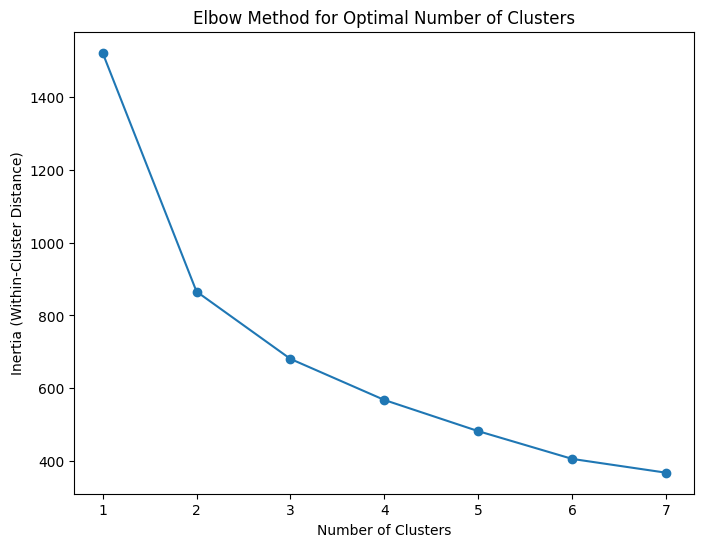

In [239]:
# Use the elbow method to choose the number of clusters

# Define the range for possible number of clusters
inertia = []
cluster_range = range(1, 8)  # Test 1 to 10 clusters; adjust as needed

for n_clusters in cluster_range:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    print(f"Modelling for cluster = {n_clusters} is done.")
    model.fit(time_series_data)
    inertia.append(model.inertia_)  # Append the inertia for each model

# Step 4: Plot the inertia to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Distance)")
plt.show()

## Graph (Smoothed)

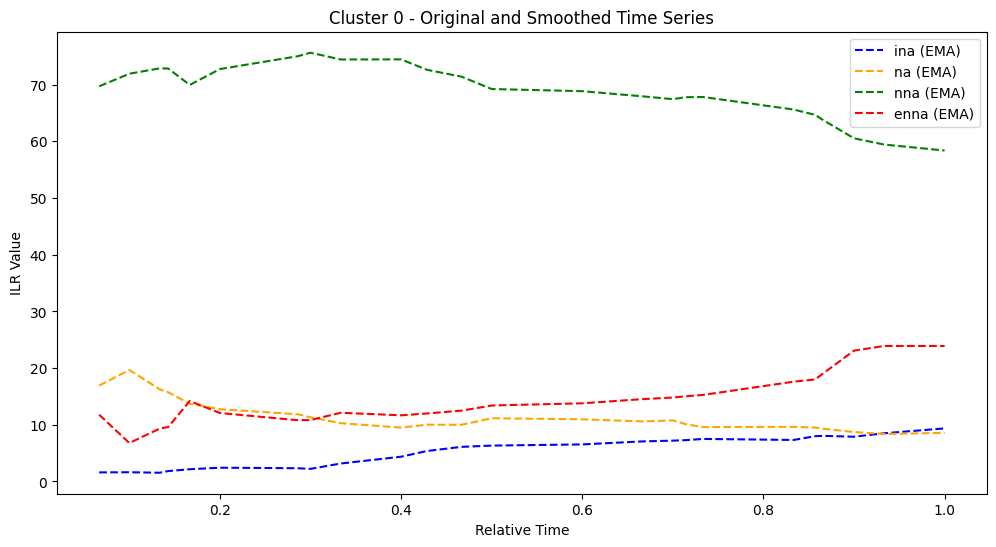

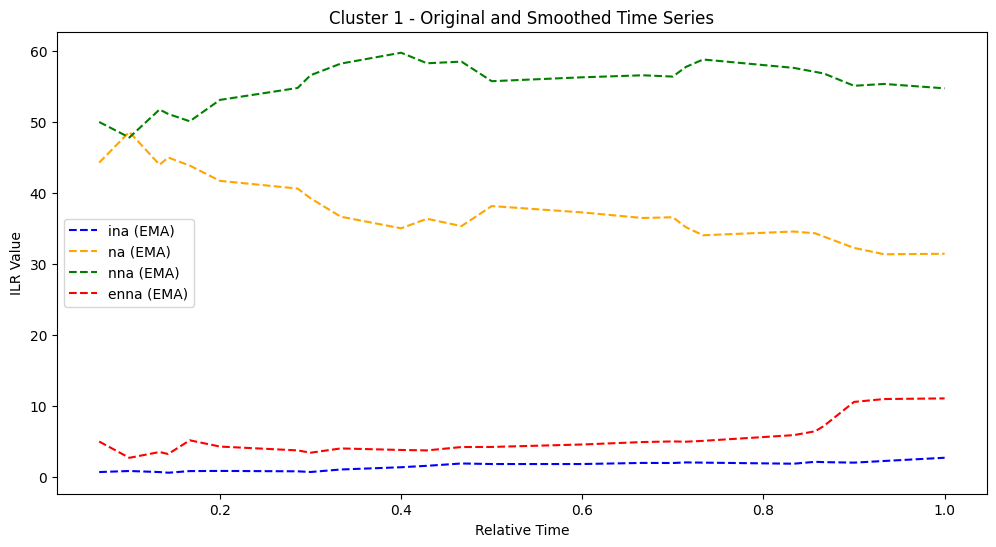

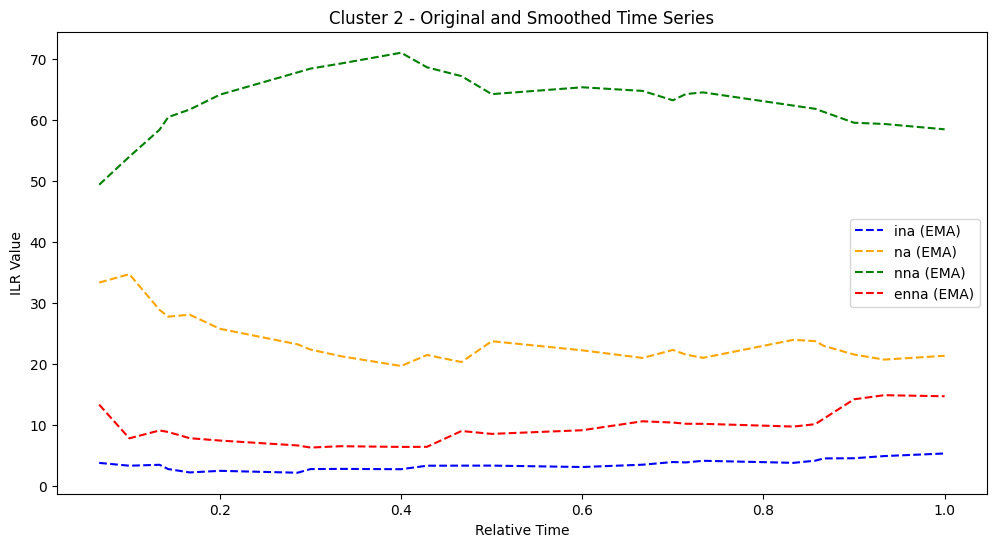

In [46]:
# Creating a relative time variable for each participant
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Define the number of clusters (adjust to the actual number of clusters)
n_clusters = 3

# Smoothing parameters
alpha = 0.05  # Smoothing factor for EMA
savgol_window = 3  # Window length for Savitzky-Golay filter
savgol_polyorder = 1  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    
    # Group by relative time and calculate the mean of ilr variables
    #mean_relative = cluster_data.groupby('relative_time')[['ilr1', 'ilr2', 'ilr3']].mean()
    mean_relative = cluster_data.groupby('relative_time')[['ina', 'na', 'nna', 'enna']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Apply Savitzky-Golay Filter smoothing
    #mean_ilr_smooth_savgol = pd.DataFrame({
    #    "ilr1": savgol_filter(mean_relative["ilr1"], window_length=savgol_window, polyorder=savgol_polyorder),
    #    "ilr2": savgol_filter(mean_relative["ilr2"], window_length=savgol_window, polyorder=savgol_polyorder),
    #    "ilr3": savgol_filter(mean_relative["ilr3"], window_length=savgol_window, polyorder=savgol_polyorder)
    #}, index=mean_relative.index)

    # Plot the original and smoothed series for each ILR variable in the cluster
    plt.figure(figsize=(12, 6))
    
    # Plot EMA smoothed series3
    #plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr1"], label="ILR1 (EMA)", linestyle="--", color="blue")
    #plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr2"], label="ILR2 (EMA)", linestyle="--", color="orange")
    #plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr3"], label="ILR3 (EMA)", linestyle="--", color="green")

    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ina"], label="ina (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["na"], label="na (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["nna"], label="nna (EMA)", linestyle="--", color="green")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["enna"], label="enna (EMA)", linestyle="--", color="red")

    # Plot Savitzky-Golay smoothed series
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr1"], label="ILR1 (Savitzky-Golay)", linestyle="-.", color="blue")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr2"], label="ILR2 (Savitzky-Golay)", linestyle="-.", color="orange")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr3"], label="ILR3 (Savitzky-Golay)", linestyle="-.", color="green")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("ILR Value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Assuming 'df' contains your data and is already prepared with 'relative_time' and cluster labels
# Creating a relative time variable for each participant
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Define the number of clusters (adjust to the actual number of clusters)
n_clusters = 4

# Smoothing parameters
alpha = 0.05  # Smoothing factor for EMA
savgol_window = 5  # Window length for Savitzky-Golay filter
savgol_polyorder = 2  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    
    # Group by relative time and calculate the mean of ilr variables
    mean_relative = cluster_data.groupby('relative_time')[['ilr1', 'ilr2', 'ilr3']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Apply Savitzky-Golay Filter smoothing
    mean_ilr_smooth_savgol = pd.DataFrame({
        "ilr1": savgol_filter(mean_relative["ilr1"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr2": savgol_filter(mean_relative["ilr2"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr3": savgol_filter(mean_relative["ilr3"], window_length=savgol_window, polyorder=savgol_polyorder)
    }, index=mean_relative.index)

    # Plot the original and smoothed series for each ILR variable in the cluster
    plt.figure(figsize=(12, 6))
    
    # Plot EMA smoothed series3
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr1"], label="ILR1 (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr2"], label="ILR2 (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr3"], label="ILR3 (EMA)", linestyle="--", color="green")


    # Plot Savitzky-Golay smoothed series
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr1"], label="ILR1 (Savitzky-Golay)", linestyle="-.", color="blue")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr2"], label="ILR2 (Savitzky-Golay)", linestyle="-.", color="orange")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr3"], label="ILR3 (Savitzky-Golay)", linestyle="-.", color="green")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("ILR Value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()

KeyError: 'cluster'

### Elbow

**Inertia Calculation**: The model.inertia_ attribute gives the sum of within-cluster distances for the given model, which helps in observing how the distances change with different cluster counts.

**Elbow Plot**: Look for the point where the plot of inertia vs. number of clusters starts to flatten, indicating diminishing returns for adding more clusters. This is typically your "elbow."

Interpreting the Elbow Plot:
- The optimal number of clusters is generally at the "elbow" point of the plot, where adding more clusters does not significantly reduce inertia.
- Choose the number of clusters right before the decrease in inertia slows down significantly.


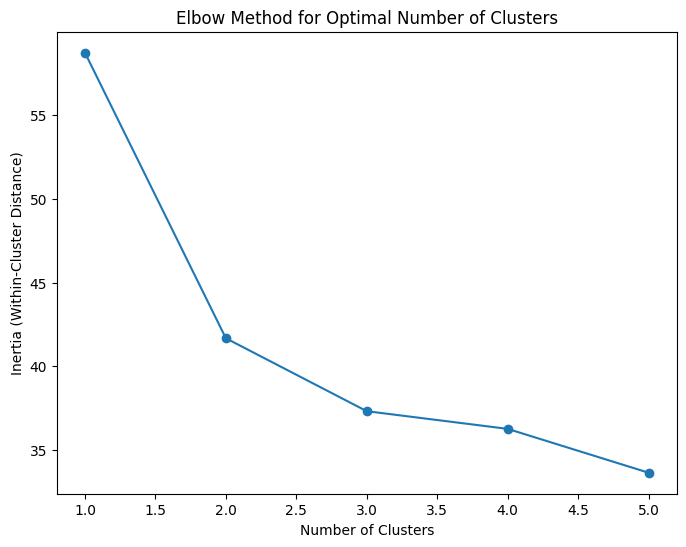

In [ ]:
# Step 1: Prepare your time series data as before
time_series_data = []
grouped = df.groupby("ID")

for participant, group in grouped:
    group_sorted = group.sort_values("time")
    time_series = group_sorted[['ilr1', 'ilr2', 'ilr3', 'excluded', 'injustice', 'personal', 'violence', 'Experiment']].values
    max_length = 16  # Adjust as appropriate for your dataset
    if len(time_series) < max_length:
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        time_series = time_series[:max_length]
    time_series_data.append(time_series)

time_series_data = np.array(time_series_data)

# Step 2: Scale the data
scaled_data = TimeSeriesScalerMeanVariance().fit_transform(time_series_data)

# Step 3: Use the elbow method to choose the number of clusters
# Define the range for possible number of clusters
inertia = []
cluster_range = range(1, 10)  # Test 1 to 10 clusters; adjust as needed

for n_clusters in cluster_range:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    model.fit(scaled_data)
    inertia.append(model.inertia_)  # Append the inertia for each model

# Step 4: Plot the inertia to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Distance)")
plt.show()

## Hierarchical with Normalizing per Experiment

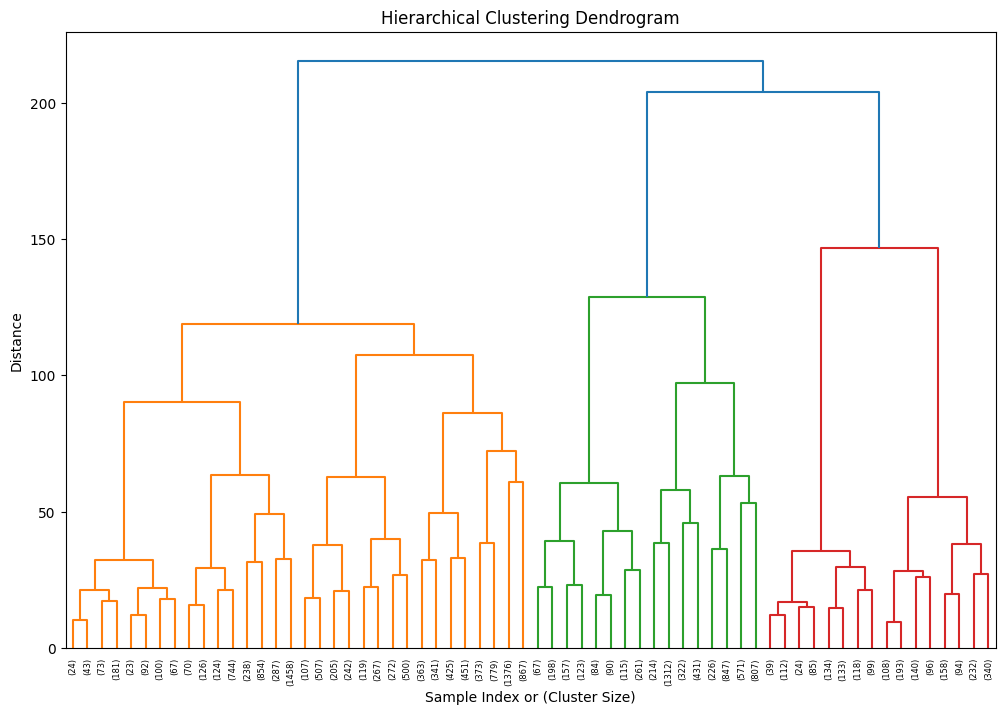

In [40]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load your data
# df = pd.read_csv('your_data.csv')  # Replace with your actual data loading line if needed

# Step 1: Normalize DVs (ilr1, ilr2, ilr3) by Experiment
def normalize_by_experiment(df, dv_columns, group_column):
    """
    Normalize specified columns within groups defined by group_column.
    """
    normalized_df = df.copy()
    for col in dv_columns:
        # Normalize each DV column within each experiment
        normalized_df[col] = df.groupby(group_column)[col].transform(lambda x: (x - x.mean()) / x.std())
    return normalized_df

# Columns to normalize
dv_columns = ['ilr1', 'ilr2', 'ilr3']
df_normalized = normalize_by_experiment(df, dv_columns, 'Experiment')

# Step 2: Prepare Data for Clustering
clustering_data = df_normalized[dv_columns + ['excluded', 'injustice', 'personal', 'violence', 'Experiment']]

# Step 3: Standardize the Data for Clustering
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Step 3.1: Check for any NaNs or Infinite values and replace them with 0
# This can prevent non-finite values from causing errors in the linkage function
clustering_data_scaled = np.nan_to_num(clustering_data_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Step 4: Perform Hierarchical Clustering
# Compute the linkage matrix
linkage_matrix = linkage(clustering_data_scaled, method='ward')

# Plot the dendrogram to inspect cluster distances
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()